# Medzy
## Overview
This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medicine.

This model is using Hugging Face's [TrOCR](https://huggingface.co/docs/transformers/en/model_doc/trocr) for classifying the handwritings.

## Get PyTorch Device

### DirectML

In [ ]:
import torch
import torch_directml

device = torch_directml.device()

### CUDA (fallback to CPU if none)

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set Up Model and Preprocessing

### Initialize IAMDataset Class

In [2]:
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['IMAGE'][idx]
        text = self.df['MEDICINE_NAME'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, 
            padding="max_length", 
            max_length=self.max_target_length
        ).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

### Loading Model and Preprocessing

In [3]:
# Load model
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("./model-output/best-OCR", local_files_only=True)
model.to(device)
model.eval()

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [4]:
# Load data
import pandas as pd

test_df = pd.read_csv("./Dataset/Testing/testing_labels.csv", delimiter = ",")

# Preprocess data
from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten") # Old model
processor = TrOCRProcessor.from_pretrained("./model-output/best-OCR")

test_dataset = IAMDataset(
    root_dir='./Dataset/Testing/testing_words/',
    df=test_df,
    processor=processor
)

# Creating Data Loader
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=32)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Testing

In [5]:
from tqdm.notebook import tqdm
from rapidfuzz import process
import re

valid_labels = test_df["MEDICINE_NAME"].unique() # Get all unique instance of the labels

def correct_text(ocr_text):
    text = re.sub(r'(.{2,})\1+', r'\1', ocr_text) # Reduces repeated patterns like 'Arolrolrol' to 'Arol'.

    best_match, _, _ = process.extractOne(text, valid_labels) # Force Classification
    
    return best_match

predicted_labels = []

### Run Inference
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))

        # Decode predictions
        decoded_predictions = [correct_text(processor.decode(ids, skip_special_tokens=True)) for ids in outputs]

        # Store results
        predicted_labels.extend(decoded_predictions)

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get all unique true labels from the dataset
unique_labels = set(test_df["MEDICINE_NAME"].astype(str))  # Ensure labels are strings

# Add "unknown" to unique labels so sklearn treats it as a valid class
unique_labels.add("unknown")

# Replace unknown predictions with "unknown"
cleaned_predictions = [
    pred if pred in unique_labels else "unknown"
    for pred in predicted_labels
]

# Compute metrics
accuracy = accuracy_score(test_df["MEDICINE_NAME"], cleaned_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_df["MEDICINE_NAME"], cleaned_predictions, labels=list(unique_labels), average="macro", zero_division=0)

# Print results
print(f"Model Performance:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Model Performance:
Accuracy: 93.33%
Precision: 92.92%
Recall: 92.15%
F1-Score: 91.99%


In [7]:
predicted_labels

['Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Aceta',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Ace',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Alatrol',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Amodis',
 'Etizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Metsina',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Atrizin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Axodin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azithrocin',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Azyth',
 'Ace',
 'Az',
 'Az',
 'Az',
 'Az',
 'Etizin',
 'Az',
 'Az',
 'Az',
 'Az',
 'Bacaid',
 'Bacaid',
 'Bacaid',
 'B

In [8]:
import json

with open('output.txt', 'w') as filehandle:
    json.dump(predicted_labels, filehandle)

In [9]:
valid_labels[57]

'Nexum'

<AxesSubplot: >

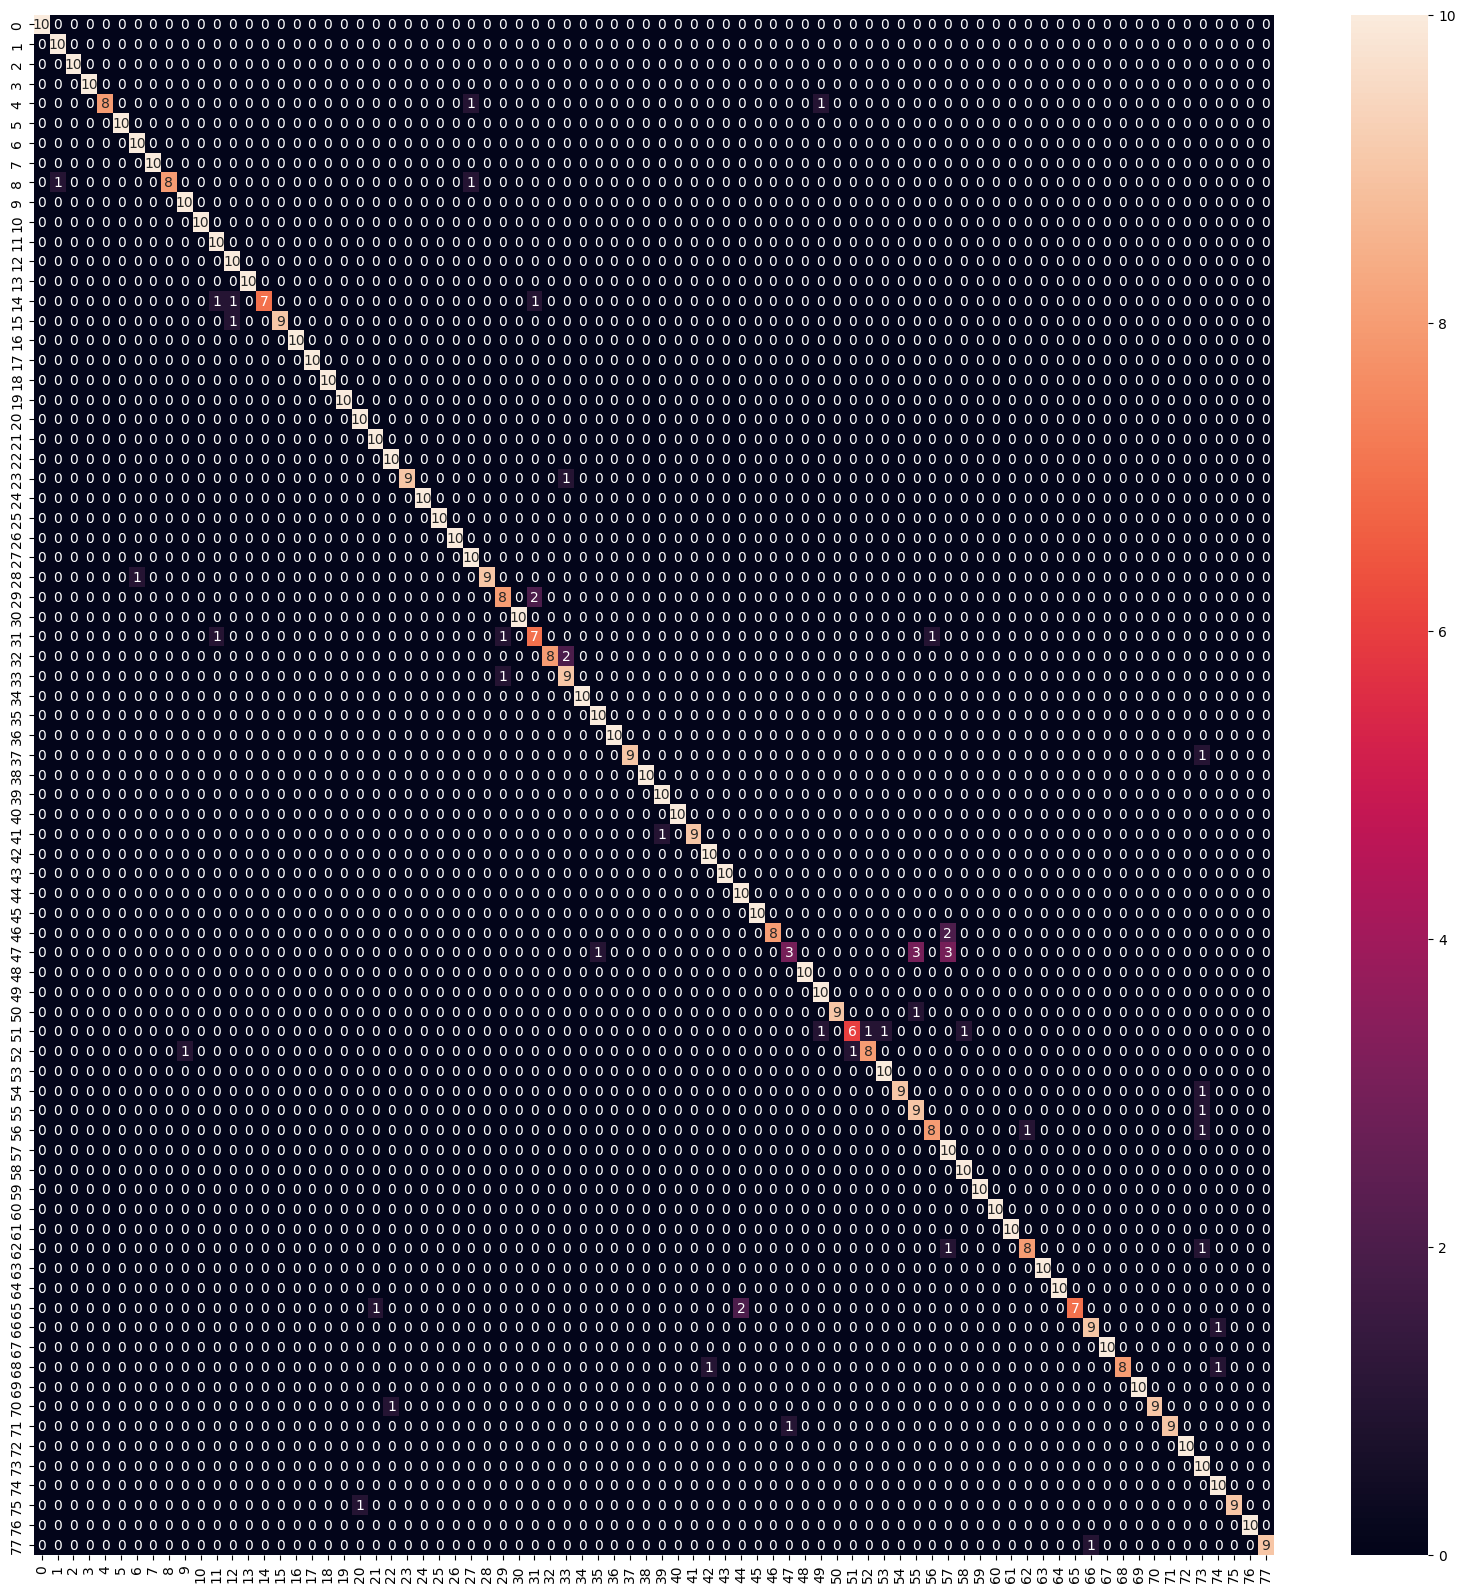

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cf_matrix = confusion_matrix(test_df["MEDICINE_NAME"], cleaned_predictions, labels=valid_labels)

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True)